# Imports

In [51]:
import pysimdamicm as ccd

import ROOT

import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib
import matplotlib.pyplot as plt

In [52]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from skimage.measure import label, regionprops

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [3]:
plt.rcParams["text.usetex"] = False

## Helpers

In [4]:
# helper to make threshold cut to image to remove noise
def apply_percentile_threshold(cal_img, percentile=95, fill_value=np.nan):
    """
    Apply a global percentile cut on the RAW calibrated image (E in e-).
    Pixels <= threshold are set to `fill_value` (np.nan by default).

    Returns:
      masked_img : 2D array with only >thr pixels kept
      thr        : numeric threshold used
      keep       : boolean mask (True for kept pixels)
    """
    thr = np.percentile(cal_img, percentile)  # compute on RAW E
    keep = cal_img > thr                      # strict '>' to drop exactly bottom p%
    masked_img = np.where(keep, cal_img, fill_value)
    return masked_img, thr, keep

In [5]:
def apply_energy_threshold(cal_img, thr_keV, fill_value=np.nan):
    """
    Apply a fixed energy threshold to a CCD image calibrated in keV.
    Pixels with energy <= thr_keV are masked out.

    Parameters
    ----------
    cal_img : 2D array (in keV)
        Calibrated CCD image.
    thr_keV : float
        Threshold in keV. Pixels <= thr_keV are suppressed.
    fill_value : number, optional
        Replacement value for masked-out pixels (default: NaN).

    Returns
    -------
    masked_img : 2D array
        Image keeping only pixels above threshold.
    thr_keV : float
        Echo of threshold used.
    keep : 2D boolean array
        True where pixel > thr_keV.
    """
    keep = cal_img > thr_keV
    masked_img = np.where(keep, cal_img, fill_value)
    return masked_img, thr_keV, keep


In [6]:
def make_samples_logE(masked_img):
    """
    Build N x 3 samples from a thresholded CCD image (in keV).
    Uses log(E) as the third feature.
    Assumes masked_img has NaNs or zeros removed already via thresholding.
    
    Returns:
      X_raw : (N,3) with columns [y, x, log(E)]
      idx_yx: (N,2) integer pixel coords [y, x]
    """
    valid = np.isfinite(masked_img) & (masked_img > 0)
    ys, xs = np.nonzero(valid)
    E = masked_img[ys, xs].astype(np.float64)

    # Use pure natural log
    logE = np.log(E)

    X_raw = np.column_stack([ys, xs, logE])
    idx_yx = np.column_stack([ys, xs])
    return X_raw, idx_yx


In [7]:
def make_samples(masked_img):
    """
    Build N x 3 samples from a thresholded CCD image (in keV).
    Uses raw E (no log) as the third feature.

    Returns:
      X_raw : (N,3) with columns [y, x, E]
      idx_yx: (N,2) integer pixel coords [y, x]
    """
    valid = np.isfinite(masked_img) & (masked_img > 0)
    ys, xs = np.nonzero(valid)
    E = masked_img[ys, xs].astype(np.float64)

    X_raw = np.column_stack([ys, xs, E])
    idx_yx = np.column_stack([ys, xs])
    return X_raw, idx_yx


In [8]:
REG_COVAR = 1e-6
RANDOM_STATE = 209

def _unscale_covariances(gmm, scaler):
    """
    Map covariances from standardized space back to original feature space.
    Handles only covariance_type='full' (what you're using).
    """
    if gmm.covariance_type != "full":
        raise ValueError("This helper currently assumes covariance_type='full'.")

    D = np.diag(scaler.scale_)
    covs_std = gmm.covariances_                 # shape: (K, d, d)
    covs_raw = np.empty_like(covs_std)
    for k in range(covs_std.shape[0]):
        covs_raw[k] = D @ covs_std[k] @ D       # Σ_raw = D Σ_std D
    return covs_raw

def fit_gmms_over_K(X_raw, K_RANGE, reg_covar=REG_COVAR, random_state=RANDOM_STATE):
    """
    Standardize features, fit a full-covariance GMM for each K.
    Returns: list of dicts with model, labels, BIC, AIC, scaler, and
             means/covariances mapped back to ORIGINAL units.
    """
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X_raw)

    results = []
    for K in K_RANGE:
        gmm = GaussianMixture(
            n_components=K,
            covariance_type="full",
            reg_covar=reg_covar,
            random_state=random_state
        )
        gmm.fit(X_std)

        # Predict labels in standardized space, but keep for reference
        labels = gmm.predict(X_std)

        # --- NEW: parameters in original (unscaled) space ---
        means_raw = scaler.inverse_transform(gmm.means_)       # shape: (K, d)
        covs_raw  = _unscale_covariances(gmm, scaler)          # shape: (K, d, d)

        bic = gmm.bic(X_std)
        aic = gmm.aic(X_std)
        results.append({
            "K": K,
            "model": gmm,
            "labels": labels,         # labels on the standardized X
            "bic": bic,
            "aic": aic,
            "scaler": scaler,
            "means_raw": means_raw,   # <-- in original units
            "covs_raw": covs_raw      # <-- in original units
        })

    results.sort(key=lambda r: r["bic"])
    return results

In [39]:
def plot_fullframe_clusters(idx_yx, labels, frame_size=(320, 640), title=None):
    H, W = frame_size
    y = idx_yx[:, 0]
    x = idx_yx[:, 1]

    # ---- Build an image where each pixel stores its cluster label ----
    img = np.full((H, W), -1, dtype=int)   # background = -1

    img[y, x] = labels

    # ---- Create color map: background white, clusters colored ----
    unique_labels = np.unique(labels)
    n_colors = unique_labels.max() + 1

    # tab20 but shifted to skip white
    base_cmap = plt.cm.tab20(np.linspace(0, 1, max(n_colors, 20)))
    # force bg = white
    colors = np.vstack([[1, 1, 1, 1], base_cmap[:n_colors]])

    cmap = ListedColormap(colors)

    # shift labels by +1 so that background (-1) becomes 0
    img_plot = img + 1

    # ---- Plot as filled square pixels ----
    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.imshow(img_plot, origin='lower', cmap=cmap, interpolation='none')

    ax.set_xlim(0, W)
    ax.set_ylim(0, H)
    ax.set_aspect('equal', 'box')
    ax.set_xlabel("Column index (x)")
    ax.set_ylabel("Row index (y)")
    ax.set_title(title if title else "GMM clusters (full frame)")

    plt.tight_layout()
    plt.show()


# Calbration

In [10]:
# Start with 1 raw image CCD (just took the first image 5)
path = "raw_img_data/avg_Image_8_Low_Temp_109_20251117_102727_2.fz"
json_file = "pysimdamicm/pysimdamicm/json/moduletest_lowtemp_image_8.json"

In [11]:
from pysimdamicm.scripts.calibrate import calibrate

In [12]:
calibrated_img = calibrate(path, json_file, save=False, return_array=True)

[1/8] Loading configuration...
[2/8] Building RawData object...
Exposure time: 0.0s
Total Read-out time: 58348.409352s
Total time (exp+readout): 58348.409352s
WARNING ERROR: Parameter ampdir will be ignored, not found in the data image header (extension 1)
WARNING ERROR: Parameter itgtime will be ignored, not found in the data image header (extension 1)
WARNING ERROR: Parameter ampl will be ignored, not found in the data image header (extension 1)
WARNING ERROR: Parameter read_time will be ignored, not found in the data image header (extension 1)
<panaSKImg> info: Fits file does not contain an skip image, Nskips sets to 1 (from header 1000).
[3/8] Preparing data...
RawData INFO.
 *********************************************************************** 
 * Define mask for sensor and over/pre-scan regions 'avg_Image_8_Low_Temp_109_20251117_102727_2.fz'
 *********************************************************************** 
  INFO: Rows and column region for the overscan, prescan and Act

In [13]:
ccds = np.vsplit(calibrated_img, 4)
ccd1, ccd2, ccd3, ccd4 = ccds

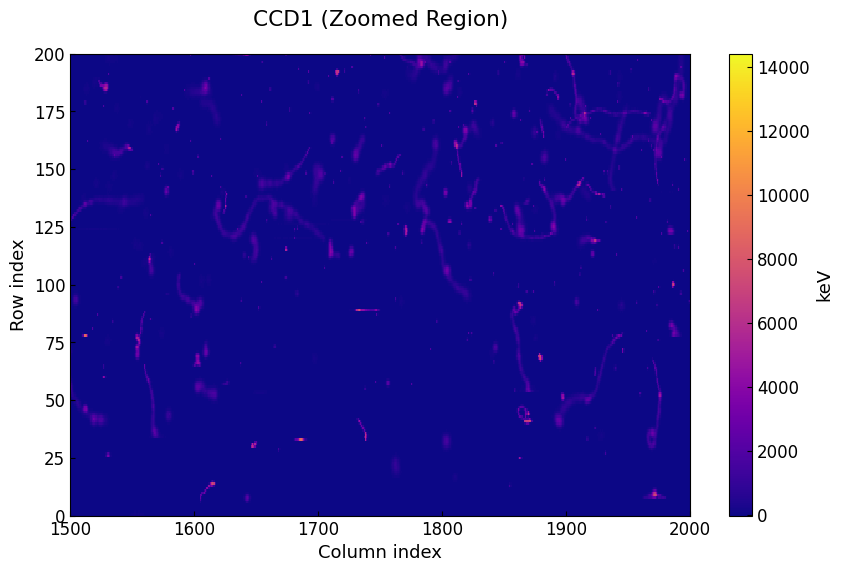

In [14]:
# your CCD1
ccd = ccd1

# region of interest
x_min, x_max = 1500, 2000
y_min, y_max = 0, 200

plt.figure(figsize=(10, 6))
cmap = plt.cm.plasma

img = plt.imshow(
    ccd,
    cmap=cmap,
    origin='lower',
    aspect='auto',
    interpolation='none'
)

plt.colorbar(img, label='keV')
plt.title("CCD1 (Zoomed Region)")
plt.xlabel("Column index")
plt.ylabel("Row index")

# zoom to defined chunk
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()


In [17]:
masked_img, thr, keep = apply_energy_threshold(ccd, thr_keV=3.7)

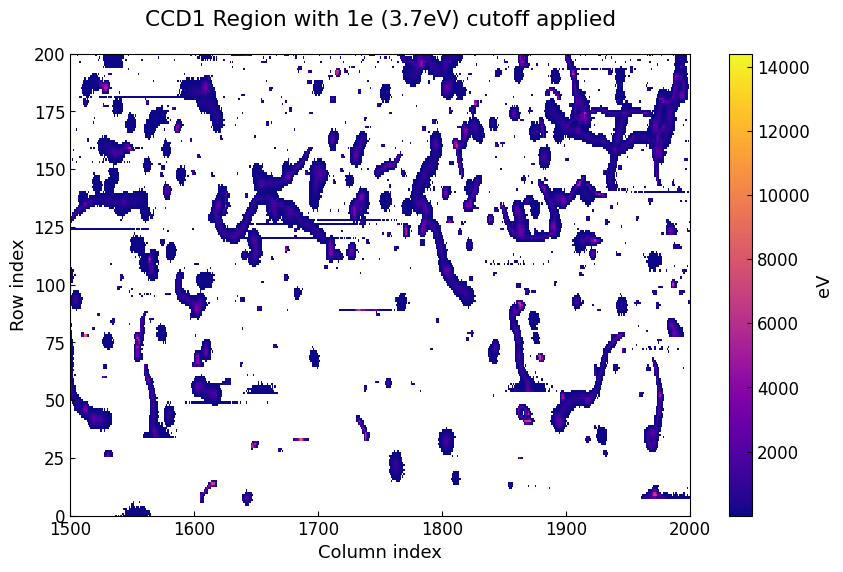

In [19]:
# region of interest
x_min, x_max = 1500, 2000
y_min, y_max = 0, 200

plt.figure(figsize=(10, 6))
cmap = plt.cm.plasma

img = plt.imshow(
    masked_img,
    cmap=cmap,
    origin='lower',
    aspect='auto',
    interpolation='none'
)

# I think this is actually just eV- maybe when WADERS clusters that what it moves into keV
plt.colorbar(img, label='eV')
plt.title("CCD1 Region with 1e (3.7eV) cutoff applied")
plt.xlabel("Column index")
plt.ylabel("Row index")

# zoom to defined chunk
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()

## 1. Without log scaling, removing noise

In [32]:
x_min = 1500
x_max = 2000
y_min = 0
y_max = 200

In [33]:
cut_ccd1 = ccd1[y_min:y_max, x_min:x_max]

In [34]:
masked_img, thr, keep = apply_energy_threshold(cut_ccd1, thr_keV=7.4)

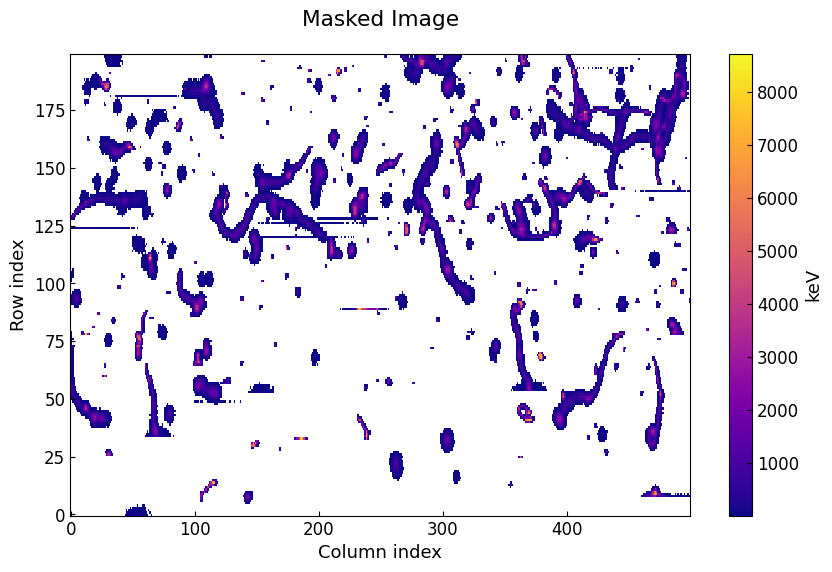

In [35]:
plt.figure(figsize=(10, 6))
cmap = plt.cm.plasma

img = plt.imshow(
    masked_img,
    cmap=cmap,
    origin='lower',
    aspect='auto',
    interpolation='none'
)

plt.colorbar(img, label='keV')
plt.title("Masked Image")
plt.xlabel("Column index")
plt.ylabel("Row index")


plt.show()

In [36]:
from scipy import ndimage as ndi

In [37]:
# assuming 'clean_img' is your speck-removed array
mask = np.isfinite(masked_img) & (masked_img > 0)
structure = ndi.generate_binary_structure(2, 2)   # 8-connected
labeled, n_clusters = ndi.label(mask, structure=structure)

print(f"Estimated number of connected clusters: {n_clusters}")

# K_range is +5, -5 around the n_clusters value found above
K_RANGE = list(range(max(1, n_clusters - 2), n_clusters + 2))
print(K_RANGE)

Estimated number of connected clusters: 274
[272, 273, 274, 275]


In [38]:
X_raw, idx = make_samples(masked_img)
results = fit_gmms_over_K(X_raw, K_RANGE)

In [40]:
best = results[0]

In [42]:
from matplotlib.colors import ListedColormap

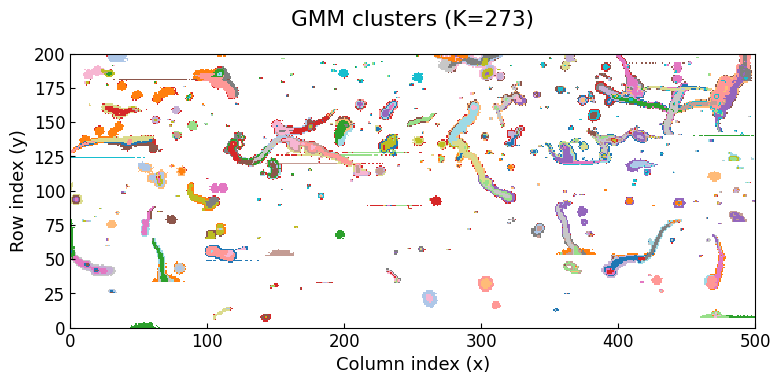

In [43]:
plot_fullframe_clusters(
    idx,
    best["labels"],
    frame_size=cut_ccd1.shape,
    title=f"GMM clusters (K={best['K']})"
)

## With log scaling, removing noise

## With log scaling, without removing noise

# WADERS

In [53]:
import uproot
import pandas as pd

In [54]:
file = "panaSKImg_clustersRec_avg_Image_8_Low_Temp_109_20251117_102727_2_ext1 (1).root"

In [56]:
with uproot.open(file) as f:
    print(f.keys())

['clustersRec;1', 'info;1', 'process_config;1']


In [57]:
clustersRec_tree = f["clustersRec"]
df = clustersRec_tree.arrays(library="pd")

In [58]:
try:
    import awkward as ak
except Exception:
    ak = None

def to_list_maybe(x):
    # Handle common array-likes
    if isinstance(x, (list, tuple, np.ndarray, pd.Series)):
        return list(x)
    # Awkward arrays
    if ak is not None:
        try:
            return ak.to_list(x)
        except Exception:
            pass
    # Some awkward objects have .to_list()
    if hasattr(x, "to_list"):
        try:
            return x.to_list()
        except Exception:
            pass
    # Not an array -> return None so we can repeat later
    return None

# --- Choose columns (drop the blockers) ---
cols = [c for c in df.columns if c not in ["RUNID", "Nclusters"]]

# Use the first row (you said there's 1 row)
row = df.iloc[0]

# Find target length (e.g., 991) from the first array-like column
N = None
for c in cols:
    seq = to_list_maybe(row[c])
    if seq is not None:
        N = len(seq)
        break
if N is None:
    raise ValueError("Couldn't find any array-like columns to expand.")

# Build dict of columns -> sequences (repeat scalars)
data = {}
for c in cols:
    seq = to_list_maybe(row[c])
    if seq is None:
        # scalar: repeat it N times
        data[c] = [row[c]] * N
    else:
        data[c] = seq

df_expanded = pd.DataFrame(data).reset_index(drop=True)

print(df_expanded.shape)  
df_expanded.head()

(1221, 57)


,DX,DY,Energy,Energy_AVG,Energy_PS,Npix,PosX,PosY,Qmax,QmaxX,...,readout_end,readout_start,seed_nsig_delta,seed_nsig_max,seed_nsig_min,seed_nsig_pixels,sigma_seed_eV,wSTD_X,wSTD_XY,wSTD_Y
0,13.0,3.0,0.551589,-657.085327,198.070648,21,438.261169,1.453099,0.045356,437.0,...,1.763462e+09,1.763404e+09,22.825567,33.671371,10.845805,"[14.133325576782227, 13.583669662475586, 19.94...",1.347009,2.909075,2.110190,0.665645
1,9.0,10.0,6.524772,16.563927,2342.986084,57,921.312500,189.578644,0.456312,921.0,...,1.763462e+09,1.763404e+09,328.148346,338.759766,10.611405,"[11.457945823669434, 11.269667625427246, 10.86...",1.347009,1.523130,1.515790,1.508413
2,8.0,8.0,23.984516,6735.193359,8612.622070,46,1398.469727,187.493744,2.389755,1398.0,...,1.763462e+09,1.763404e+09,1763.489502,1774.119995,10.630532,"[23.964277267456055, 15.71530818939209, 13.569...",1.347009,1.149206,1.132223,1.114982
3,3.0,2.0,5.822162,1886.595825,2090.685547,5,1733.095947,184.680054,3.588612,1733.0,...,1.763462e+09,1.763404e+09,2650.236084,2664.134277,13.898038,"[1257.5697021484375, 125.31927490234375, 2664....",1.347009,0.305172,0.394151,0.466454
4,4.0,1.0,1.285796,298.882690,461.717712,4,534.557800,1.000000,0.631432,535.0,...,1.763462e+09,1.763404e+09,443.776703,468.766083,24.989376,"[24.989376068115234, 416.4757080078125, 468.76...",1.347009,0.626012,0.442658,0.000000


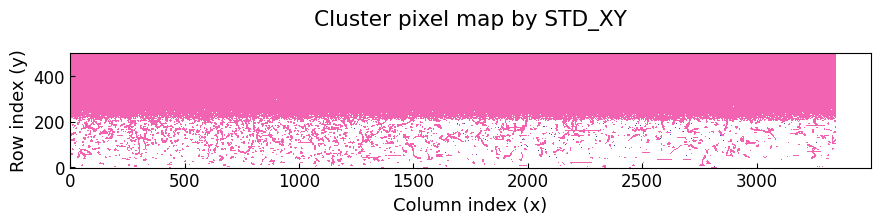

In [60]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

H, W = 500, 3500

# label map: 0 = STD_XY <= 1, 1 = STD_XY > 1, NaN = background
labels = np.full((H, W), np.nan, dtype=float)

for _, row in df_expanded.iterrows():
    xs = np.array(row["pixels_x"], dtype=int)
    ys = np.array(row["pixels_y"], dtype=int)

    # keep in-bounds
    mask = (xs >= 0) & (xs < W) & (ys >= 0) & (ys < H)
    xs, ys = xs[mask], ys[mask]

    if row["STD_XY"] <= 1.0:
        labels[ys, xs] = 0.0
    else:
        labels[ys, xs] = 1.0

# blue + pink colormap
cmap = ListedColormap([
    "#3B4CC0",  # blue
    "#F264B1",  # pink
])
cmap.set_bad("white")  # background

plt.figure(figsize=(9, 4.5))
plt.imshow(labels, origin="lower", cmap=cmap, vmin=0, vmax=1, interpolation="none")

plt.title("Cluster pixel map by STD_XY")
plt.xlabel("Column index (x)")
plt.ylabel("Row index (y)")

plt.tight_layout()
plt.show()

In [59]:
plt.figure(figsize=(9, 4.5))
plt.imshow(labels, origin="lower", cmap=cmap, vmin=0, vmax=1, interpolation="none")

plt.title("Cluster Map")
plt.xlabel("Row index (x)")
plt.ylabel("Column index (y)")

# -------------------------------
# ZOOM TO THE REQUESTED CCD REGION
# -------------------------------
plt.xlim(1500, 2000)   # x range
plt.ylim(0, 200)       # y range

plt.tight_layout()
plt.show()


NameError: name 'labels' is not defined

<Figure size 900x450 with 0 Axes>

In [50]:
count = df_expanded[(df_expanded["PosX"] >= 1500) & (df_expanded["PosX"] <= 2000)].shape[0]
print(count)


NameError: name 'df_expanded' is not defined